In [343]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

class ForceAtlas2:
    def __init__(self, G, iterations=5000, damping=0.2, linlog_mode=False,
                 outbound_attraction_distribution=False, barnes_hut_optimize=False,
                 barnes_hut_theta=0.5, scalingRatio=2.0, strongGravityMode=False,
                 gravity=1.0, jitterTolerance=1.0, barnes_hut_optimize_barnes_hut_degree=0,
                 barnes_hut_optimize_speedup=1):
        self.G = G
        self.iterations = iterations
        self.damping = damping
        self.linlog_mode = linlog_mode
        self.outbound_attraction_distribution = outbound_attraction_distribution
        self.barnes_hut_optimize = barnes_hut_optimize
        self.barnes_hut_theta = barnes_hut_theta
        self.scalingRatio = scalingRatio
        self.strongGravityMode = strongGravityMode
        self.gravity = gravity
        self.jitterTolerance = jitterTolerance
        self.barnes_hut_optimize_barnes_hut_degree = barnes_hut_optimize_barnes_hut_degree
        self.barnes_hut_optimize_speedup = barnes_hut_optimize_speedup

    def forceatlas2(self):
        pos = nx.spring_layout(self.G)
        node_cnt = len(pos)
        node_weight = {}
        for node in self.G.nodes():
            node_weight[node] = 1.0
        node_indices = dict(zip(pos.keys(), range(node_cnt)))
        distances = np.zeros((node_cnt, node_cnt))
        for u, v in self.G.edges():
            i, j = node_indices[u], node_indices[v]
            d = np.linalg.norm(pos[u] - pos[v])
            distances[i][j] = d
            distances[j][i] = d
        outbound_attraction = 1 if self.outbound_attraction_distribution else 0
        barnes_hut = 1 if self.barnes_hut_optimize else 0
        forces = forceatlas2(
            node_cnt, self.iterations, self.damping, self.gravity, self.scalingRatio,
            self.jitterTolerance, self.barnes_hut_theta, self.linlog_mode, outbound_attraction,
            self.strongGravityMode, barnes_hut, self.barnes_hut_optimize_barnes_hut_degree,
            self.barnes_hut_optimize_speedup, distances, pos, node_weight
        )
        new_pos = dict(zip(node_indices.keys(), forces))
        return new_pos

def forceatlas2(
    n, iterations, damping, gravity, scalingRatio, jitterTolerance, barnesHutTheta, linLogMode,
    outboundAttractionDistribution, strongGravityMode, barnesHutOptimize, barnesHutDegree,
    barnesHutOptimizeSpeedup, distances, pos, nodeWeight
):
    dt = 0.1
    ks = np.sqrt(1.0 / n)
    ks2 = 2 * np.sqrt(1.0 / n)
    fa2 = np.zeros((n, 2))
    v = np.zeros((n, 2))
    w = np.zeros((n, 2))
    previous_fa2 = np.zeros((n, 2))
    previous_v = np.zeros((


SyntaxError: unexpected EOF while parsing (75468252.py, line 61)

In [313]:
import networkx as nx
import matplotlib.pyplot as plt
import os
from fa2 import ForceAtlas2
from pyglet.gl import *

import jiggle
import random


In [314]:
def load_file(file_path):
#     data_path = "../../data/ground-truth/Sparse/n=200d=6"
    f = open(file_path)
    edge_list = []
    data_list = []
    for line in f.readlines():
        data_list.append(line.strip())
    num_nodes = int (data_list.pop(0)) #Pop out the number of nodes 

    for i in range(num_nodes+1,len(data_list)):
        edge_list.append(tuple([int(data_list[i].strip('\n').split(" ")[0]), int(data_list[i].strip('\n').split(" ")[1])]))
    return edge_list, file_path.split("/")[-1]

In [315]:
def store(pos_dict, edges_list, target_graph_path):
    with open(target_graph_path,"w+") as f:
        f.write(str(len(pos_dict)) + "\n")
        for num, pos in pos_dict.items():
            f.write(str(num) + " " + str(float(pos[0])) + " " + str(float(pos[1])) + "\n")
        f.write(str(len(edges_list)) + "\n")
        for edge in edges_list:
            f.write(str(edge[0]) + " " + str(edge[1]) + "\n")
        f.close()


In [316]:
def fr_fd(edges_list,type):
    G = nx.Graph()
    for edge in edges_list:
        G.add_edge(edge[0], edge[1])
        
    # Define spring layout and draw graph
    pos_dict = nx.fruchterman_reingold_layout(G, k=0.3, iterations=100)
    nx.draw(G, pos_dict, with_labels=True)
    
    # Set edge weights based on type
    if type == 'Sparse':
        weights = [random.uniform(0, 0.5) for _ in G.edges()]
    elif type == 'Uniform':
        weights = [1 for _ in G.edges()]
    else:
        raise ValueError("Invalid type. Choose 'Sparse' or 'Uniform'.")
            
    # Set edge weights and draw graph
    nx.draw_networkx_edges(G, pos_dict, width=weights)

    return pos_dict

In [317]:
def kk_fd(edges_list, type):
    G = nx.Graph()
    for edge in edges_list:
        G.add_edge(edge[0], edge[1])
        
    # Define Kamada-Kawai layout and draw graph
    pos_dict = nx.kamada_kawai_layout(G)
    nx.draw(G, pos_dict, with_labels=True)
    
    # Set edge weights based on type
    if type == 'Sparse':
        weights = [random.uniform(0, 0.5) for _ in G.edges()]
    elif type == 'Uniform':
        weights = [1 for _ in G.edges()]
    else:
        raise ValueError("Invalid type. Choose 'Sparse' or 'Uniform'.")
        
    # Set edge weights and draw graph
    nx.draw_networkx_edges(G, pos_dict, width=weights)
    plt.show()
    return pos_dict

In [338]:


def fa2_fd(edges_list, type):
    import networkx as nx
    import numpy as np
    from fa2 import ForceAtlas2

    # Create a graph with some edges
    edges = edges_list
    G = nx.Graph()
    G.add_edges_from(edges)

    G = nx.random_geometric_graph(400, 0.2)

    forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=True,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=True)

    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)



    # Print the resulting node positions
    print(positions)


In [339]:


# Define function to create graph
def jiggle_fd(edges_list, type):
    G = nx.Graph()
    for edge in edges_list:
        G.add_edge(edge[0], edge[1])
        
    # Define Kamada-Kawai layout and draw graph
    pos_dict = nx.jiggle_layout(G)
    nx.draw(G, pos_dict, with_labels=True)
    
    # Set edge weights based on type
    if type == 'Sparse':
        weights = [random.uniform(0, 0.5) for _ in G.edges()]
    elif type == 'Uniform':
        weights = [1 for _ in G.edges()]
    else:
        raise ValueError("Invalid type. Choose 'Sparse' or 'Uniform'.")
        
    # Set edge weights and draw graph
    nx.draw_networkx_edges(G, pos_dict, width=weights)
    plt.show()
    return pos_dict


In [340]:
def fa2_nx(edges_list, type):


# Define function to create graph
    G = nx.Graph()
    for edge in edges_list:
        G.add_edge(edge[0], edge[1])
        
    # Define Kamada-Kawai layout and draw graph
    pos_dict = nx.force_atlas_2_layout(G)
    nx.draw(G, pos_dict, with_labels=True)
    
    # Set edge weights based on type
    if type == 'Sparse':
        weights = [random.uniform(0, 0.5) for _ in G.edges()]
    elif type == 'Uniform':
        weights = [1 for _ in G.edges()]
    else:
        raise ValueError("Invalid type. Choose 'Sparse' or 'Uniform'.")
        
    # Set edge weights and draw graph
    nx.draw_networkx_edges(G, pos_dict, width=weights)
    plt.show()
    return pos_dict


In [341]:
def generate(file_path, target_graph_path):
    edges_list, fname = load_file(file_path)
    type_list = ["Sparse", "Uniform"]
    for type in type_list:
        target_type_path = os.path.join(target_graph_path, type)
        fr_path = os.path.join(target_type_path,"FR",fname+".graph")
        pos_dict = fr_fd(edges_list, type)
        store(pos_dict, edges_list, fr_path)

        fa2_path = os.path.join(target_type_path,"FA2",fname+".graph")
        pos_dict = fa2_fd(edges_list, type)
        store(pos_dict, edges_list, fa2_path)

        kk_path = os.path.join(target_type_path,"KK",fname+".graph")
        pos_dict = kk_fd(edges_list, type)
        store(pos_dict, edges_list, kk_path)

        # fru_path = os.path.join(target_type_path,"FRU",fname+".graph")
        # pos_dict = fru_fd(edges_list, type)
        # store(pos_dict, edges_list, fru_path)

        # fdge_path = os.path.join(target_type_path,"FDGE",fname+".graph")
        # pos_dict = fdge_fd(edges_list, type)
        # store(pos_dict, edges_list, fdge_path)

        # jiggle_path = os.path.join(target_type_path,"JIGGLE",fname+".graph")
        # pos_dict = jiggle_fd(edges_list, type)
        # store(pos_dict, edges_list, jiggle_path)




AttributeError: module 'networkx' has no attribute 'to_scipy_sparse_matrix'

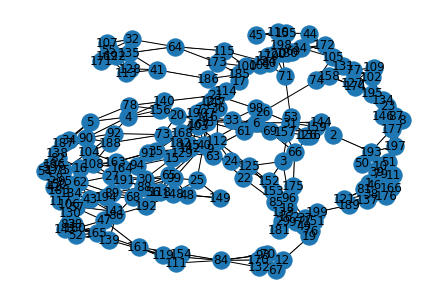

In [342]:
generate("../../Data/ground-truth/Sparse/n=200d=6","../../Data/new_graph_file_by_kevin")